<a href="https://colab.research.google.com/github/marcinwolter/GammaFactory/blob/main/tracks_in_magnetic_field.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Charged particles in constant magnetic fields**

The equation of motion for a charged particle in a magnetic field is as follows:

$\frac{d\vec{v}}{dt}=qm(\vec{v} \times \vec{B} )$

We choose to put the particle in a field that is written

$\vec{B} = B\cdot \vec{e}_x$

We thus expect the particle to rotate in the (y,z) plane while moving along the x axis.

Let's see how we can implement this using the integrators found in the scientific python stack.



In [110]:
# imports
import numpy as np
from scipy.integrate import ode

Here we define the magnetic field B

In [111]:
def B(x):
  Bx = 1.+0.1*x[0]
  By = 0.02
  Bz = 0.
  return [Bx,By,Bz]

To use ode, we need to define the derivatives of velocity, which is computed using the Lorentz force and of position, which is just velocity:

In [112]:
def newton(t, Y, q, m):
    """Computes the derivative of the state vector y according to the equation of motion:
    Y is the state vector (x, y, z, u, v, w) === (position, velocity).
    returns dY/dt.
    """
   
    #x, y, z = Y[0], Y[1], Y[2]
    #u, v, w = Y[3], Y[4], Y[5]

    alpha = q / m * np.cross(Y[3:],B(Y[:3]))

    Y_out = np.concatenate((Y[3:],alpha))

    return Y_out
    #return np.array([u, v, w, alpha[0], alpha[1], alpha[2]])

In [113]:
r = ode(newton).set_integrator('dopri5')

Finally, we need to define initial conditions:



In [114]:
t0 = 0
x0 = np.array([0, 0, 0])
v0 = np.array([1, 1, 0])
initial_conditions = np.concatenate((x0, v0))

Let's now set the conditions on our integrators and solve the prolem using time stepping. We assume the charged particle has unit mass and unit charge.

In [115]:
r.set_initial_value(initial_conditions, t0).set_f_params(1.0, 1.0)

positions = []
t1 = 50
dt = 0.05
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    positions.append(r.y[:3]) # keeping only position, not velocity

positions = np.array(positions)

Results in 2D

In [116]:
%matplotlib inline
import matplotlib.pyplot as plt

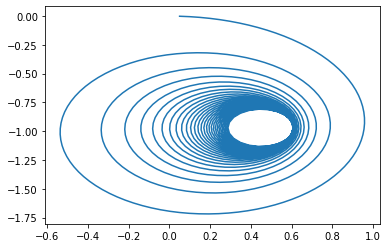

In [117]:
plt.plot(positions[:, 1], positions[:, 2])

Results in 3D

In [118]:
import matplotlib as mpl

Text(0.5, 0, 'z')

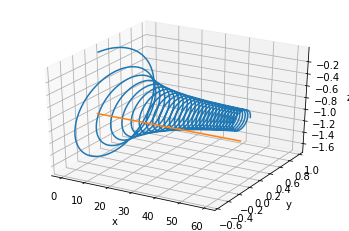

In [119]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(positions[:, 0], positions[:, 1], positions[:, 2])

B1 = np.array([x0[0], x0[1], -1])
B2 = np.array([60, 0, 0])
B_axis = np.vstack((B1, B1 + B2))
ax.plot3D(B_axis[:, 0], 
         B_axis[:, 1],
         B_axis[:, 2])
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
#ax.text3D((B1 + B2)[0], (B1 + B2)[1], (B1 + B2)[2], "B field")

Just for fun: found an example how to make a movie.

In [120]:
from tempfile import NamedTemporaryFile
import base64 
from matplotlib import animation
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        f = NamedTemporaryFile(suffix='.mp4', delete=False)
        anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
        f.flush()
        video = open(f.name, "rb").read()
        f.close()
        anim._encoded_video = base64.b64encode(video).decode('utf-8')
    
    return VIDEO_TAG.format(anim._encoded_video)

In [121]:
from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [122]:
FRAMES = 50
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def init():
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
# animation function.  This is called sequentially
def animate(i):
    current_index = int(positions.shape[0] / FRAMES * i)
    ax.cla()
    ax.plot3D(positions[:current_index, 0], 
              positions[:current_index, 1], 
              positions[:current_index, 2])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
# call the animator.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=FRAMES, interval=100)

# call our new function to display the animation
display_animation(anim)